In [15]:
# importing libraries
from rectipy import Network, random_connectivity
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, norm
from scipy.signal import find_peaks
import yaml

## Define distribution and parameters

In [16]:
# generate the lorenzian distribution
def lorentzian(n: int, eta: float, delta: float, lb: float, ub: float):
    samples = np.zeros((n,))
    for i in range(n):
        s = cauchy.rvs(loc=eta, scale=delta)  # stands for random variates
        while s <= lb or s >= ub:             # MC (rejection) sampling 
            s = cauchy.rvs(loc=eta, scale=delta)
        samples[i] = s
    return samples

In [17]:
# necessary parameters for the adex.
# model parameters
N = 1000
p = 0.2
C = 100.0
k = 0.7
v_r = -60.0
v_t = -40.0
Delta = 2.5
eta = 0.0
a = 0.03
b = 80
d = 10.0
g = 15.0
E_r = 0.0
tau_s = 6.0
v_spike = 1000.0
v_reset = -1000.0
# Add additional parameters for the AdEx model
C_adex = 281.0
delta_T = 2.5
g_adex = 30.0 
a_adex = 4.0
v_r_adex = -70.6
b_adex = 80.5
tau_w = 144.0
eta = 0.0

In [18]:
# # define inputs
# T = 250.0 
# cutoff = 20.0 
# dt = 1e-2
# dts = 1e-1
# # inp = np.zeros((int(T/dt), 1)) + 25.0
# # inp[:int(cutoff*0.5/dt), 0] -= 15.0
# # inp[int(750/dt):int(2000/dt), 0] += 30

# inp = (np.zeros((int(T/dt), 1)) + 25.0) * 100
# inp[:int(cutoff*0.5/dt), 0] -= 15.0

# # Create a ramp current
# ramp_up = np.linspace(25.0, 55.0, int((T - 2 * cutoff) / (2 * dt)))
# ramp_down = np.linspace(55.0, 25.0, int((T - 2 * cutoff) / (2 * dt)))

# inp[int(cutoff/dt):int((cutoff + len(ramp_up) * dt)/dt), 0] = ramp_up
# # inp[int((cutoff + len(ramp_up) * dt)/dt):int((cutoff + len(ramp_up) * dt + len(ramp_down) * dt)/dt), 0] = ramp_down
# inp = inp * 10

T = 500.0
# cutoff = 500.0
dt = 1e-3
dts = 1e-1
inp = np.ones((int(T/dt), 1))
print(len(inp))

500000


In [19]:
# # Plot the inp array
# plt.figure(figsize=(10, 2))
# plt.plot(np.arange(len(inp)) * dt, inp, label='Input Signal')
# plt.xlabel('Time (ms)')
# plt.ylabel('Input current (pA)')
# plt.title('Input Signal over Time')
# plt.legend()
# plt.show()

In [20]:
# define lorentzian of etas
thetas = lorentzian(N, eta=v_t, delta=Delta, lb=v_r, ub=0.0)

# define connectivity
W = random_connectivity(N, N, p, normalize=True)

 

## Running the Models

In [ ]:
## ADEX VERSION


node_vars_adex = { "eta": eta, "v_r": v_r_adex, "delta_T" : delta_T,  "v_theta": thetas,  "E_r": E_r, 
                  "C": C_adex, "a": a_adex, "b": b_adex, "tau_w": tau_w, "g": g, "tau_s": tau_s, "v" : v_t}


# initialize model
net = Network(dt=dt, device="cpu")  # we need to change all the node vars etc for the adex model
net.add_diffeq_node("snn", "/Users/utilizator/Desktop/THESIS CODE/gast_paper/config/adex_snn/rs", weights=W, source_var="s", target_var="s_in",
                    input_var="I_ext", output_var="s", spike_var="spike", reset_var="v", to_file=False,
                    node_vars=node_vars_adex.copy(), op="rs_op", spike_reset=v_r, spike_threshold=thetas,
                    verbose=False, clear=True)

# bigger current input for AdEx
# inp = inp

# perform simulation
obs = net.run(inputs=inp, sampling_steps=int(dts/dt), record_output=True, verbose=True)
res_snn_adex = obs.to_dataframe("out")

KeyError: 'out'

In [ ]:
# # troubleshooting why only plotting up till 4 ms
# t = res_snn_adex.index
# values = res_snn_adex.values
# # print(t, values, res_snn_adex)
# index = 43  # specify the neuron index you want to follow

# for i in range(len(t)):
#     print(f"Time: {t[i]}, voltage: {values[i, index]}")

-39 seems to be the threshold and then it jumps to -60 and down each iternation

note: i am getting NaN for later timesteps for voltage so also synaptic input and adaptation. i would think there is no interaction i guess!? so hence no continuous activity? idk

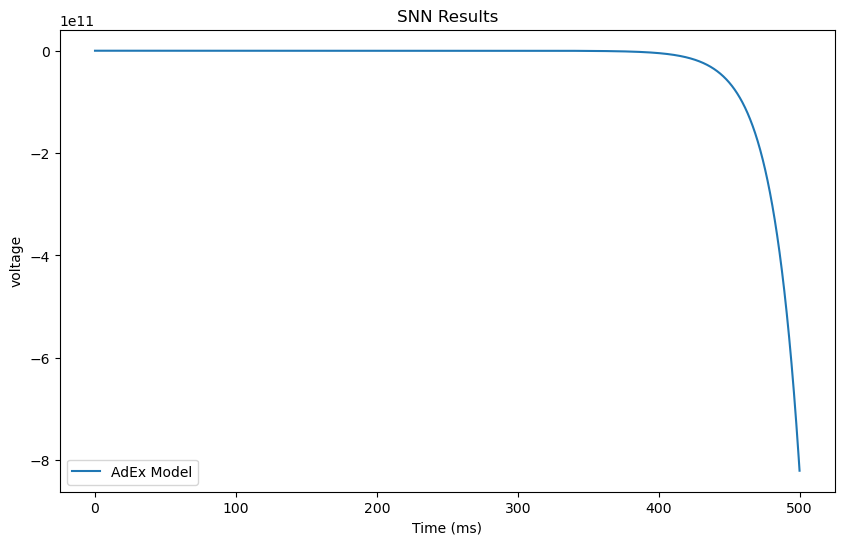

In [ ]:
# plot the synaptic output 
## just the AdEx model
t = res_snn_adex.index
# print(t, res_mf_adex['s'])

plt.figure(figsize=(10, 6))
plt.plot(t, res_snn_adex[43], label='AdEx Model')
plt.xlabel('Time (ms)')
plt.ylabel('rate')
plt.title('SNN Results')
plt.legend()
plt.show()

In [ ]:
# initialize model
node_vars_ik = {"C": C, "k": k, "v_r": v_r, "v_theta": thetas, "eta": eta, "tau_u": 1/a, "b": b, "kappa": d,
             "g": g, "E_r": E_r, "tau_s": tau_s, "v": v_t}

# initialize model
net = Network(dt=dt, device="cpu")  # we need to change all the node vars etc for the adex model
net.add_diffeq_node("snn", "/Users/utilizator/Desktop/THESIS CODE/gast_paper/config/ik_snn/rs", weights=W, source_var="s", target_var="s_in",
                    input_var="I_ext", output_var="s", spike_var="spike", reset_var="v", to_file=False,
                    node_vars=node_vars_ik.copy(), op="rs_op", spike_reset=v_reset, spike_threshold=v_spike,
                    verbose=False, clear=True)

# perform simulation
obs = net.run(inputs=inp, sampling_steps=int(dts/dt), record_output=True, verbose=True)
res_snn_ik = obs.to_dataframe("out")


Progress: 0/500000 integration steps finished.
Progress: 100/500000 integration steps finished.
Progress: 200/500000 integration steps finished.
Progress: 300/500000 integration steps finished.
Progress: 400/500000 integration steps finished.
Progress: 500/500000 integration steps finished.
Progress: 600/500000 integration steps finished.
Progress: 700/500000 integration steps finished.
Progress: 800/500000 integration steps finished.
Progress: 900/500000 integration steps finished.
Progress: 1000/500000 integration steps finished.
Progress: 1100/500000 integration steps finished.
Progress: 1200/500000 integration steps finished.
Progress: 1300/500000 integration steps finished.
Progress: 1400/500000 integration steps finished.
Progress: 1500/500000 integration steps finished.
Progress: 1600/500000 integration steps finished.
Progress: 1700/500000 integration steps finished.
Progress: 1800/500000 integration steps finished.
Progress: 1900/500000 integration steps finished.
Progress: 20

In [ ]:
# t = res_snn_ik.index
# values = res_snn_ik.values
# # print(t, values, res_snn_adex)
# index = 100  # specify the neuron index you want to follow

# for i in range(len(t)):
#     print(f"Time: {t[i]}, adaptation: {values[i, index]}")

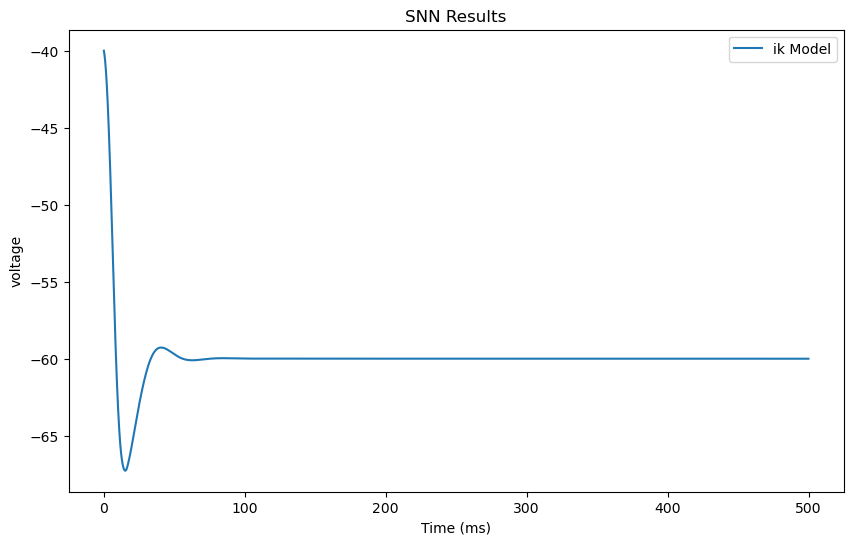

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, res_snn_ik[43], label='ik Model')
plt.xlabel('Time (ms)')
plt.ylabel('rate')
plt.title('SNN Results')
plt.legend()
plt.show()

In [ ]:
# t = res_snn_ik.index
# # print(t, res_mf_adex['s'])

# plt.figure(figsize=(10, 6))
# plt.plot(t, np.mean(res_snn_ik, axis=1), label='IK Model')
# plt.xlabel('Time (ms)')
# plt.ylabel('voltage')
# plt.title('SNN Results')
# plt.legend()
# plt.show()

## Ploting the results

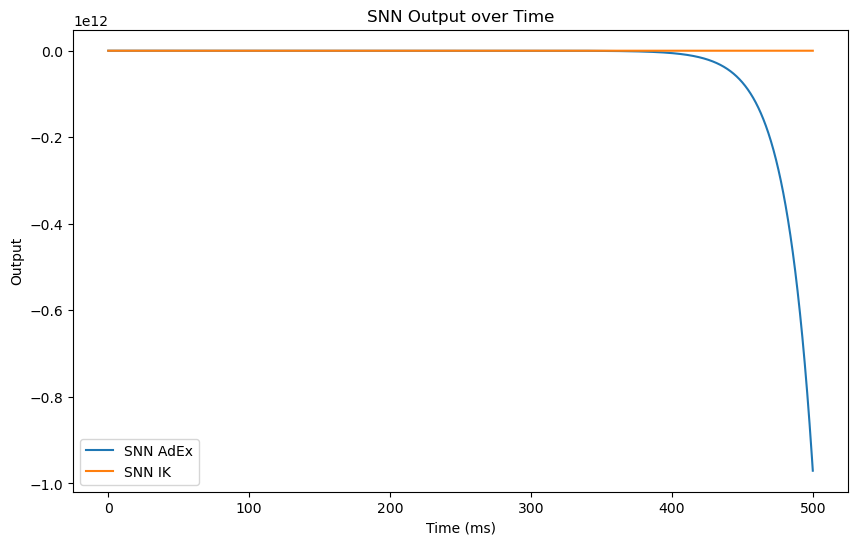

In [ ]:
# # Plot the results of both
plt.figure(figsize=(10, 6))
plt.plot(res_snn_adex.index, np.mean(res_snn_adex, axis=1), label='SNN AdEx')
plt.plot(res_snn_ik.index, np.mean(res_snn_ik, axis=1), label='SNN IK')
plt.xlabel('Time (ms)')
plt.ylabel('rate')
plt.title('SNN Output over Time')
plt.legend()
plt.show()